# Three researches making lunch plans



<a href="https://colab.research.google.com/github/google-deepmind/concordia/blob/main/examples/magic_beans_for_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np
import sentence_transformers

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.language_model import gpt_model
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting
from openai import AzureOpenAI
from tqdm import tqdm, trange

/home/yannikkellerde/miniconda3/envs/concordia/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# @title Language Model - pick your model and provide keys

# By default this colab uses GPT-4, so you must provide an API key.
# Note that it is also possible to use local models or other API models,
# simply replace this cell with the correct initialization for the model
# you want to use.
load_dotenv(os.path.expanduser("~/.env"), override=True)
GPT_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")  # @param {type: 'string'}
ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
GPT_MODEL_NAME = "gpt-4o-mini"  # @param {type: 'string'}
# GPT_MODEL_NAME = 'gpt-35-turbo-16k' #@param {type: 'string'}

if not GPT_API_KEY:
  raise ValueError("GPT_API_KEY is required.")

client = AzureOpenAI(
    api_key=GPT_API_KEY,
    api_version="2024-02-01",
    azure_endpoint=ENDPOINT,
)

model = gpt_model.GptLanguageModel(
    client=client,
    model_name=GPT_MODEL_NAME,
    request_logging_file="request_logs.json",
)

In [3]:
# Check if the model setup is working
model.sample_text(
    "What activities are available at a lab retreat in Bavaria?",
    max_tokens=1000,
)

'Activities at a lab retreat in Bavaria may include team-building exercises, hiking in the picturesque Alps, workshops on research collaboration, outdoor sports like cycling or kayaking, cultural excursions to local castles, and evening social events featuring traditional Bavarian cuisine.'

In [4]:
model.stats

{'requests': 1, 'input_tokens': 92, 'completion_tokens': 47}

In [5]:
# Setup sentence encoder
st_model = sentence_transformers.SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2'
)
embedder = lambda x: st_model.encode(x, show_progress_bar=False)

## Configuring the generic knowledge of players and GM.

In [6]:
# @title Make the clock
TIME_STEP = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=9, day=15)

START_TIME = datetime.datetime(hour=12, year=2024, month=9, day=16)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME, step_sizes=[TIME_STEP, datetime.timedelta(seconds=30)]
)

In [7]:
# @title Importance models
importance_model = importance_function.AgentImportanceModel(model)
importance_model_gm = importance_function.ConstantImportanceModel()

In [8]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    (
        'The Center for Herbivores and Mammals (CHM) is a research lab at the'
        ' Charles Darwin Institute for Animal Development (CDAD) in Berlin'
        ' Charlottenburg.'
    ),
    'Close to the lab there is a Chinese Restaurant and a Tex-Mex Restaurant.',
    'There is a canteen in the CDAD Institute building.',
    'At CHM there are PhD students, postdocs, and a professor.',
    (
        'Yesterday, Laurel lent Tommy 15 euros as he did not have any cash with'
        ' him.'
    ),
    (
        'Laurel, Roberto and Tommy know each other well and chat in concise,'
        ' informal language.'
    ),
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)

The Center for Herbivores and Mammals (CHM) at the Charles Darwin Institute for Animal Development in Berlin features a team of PhD students, postdocs, and a professor. Nearby, there are dining options, including a Chinese and a Tex-Mex restaurant, as well as a canteen within the institute. Laurel, Roberto, and Tommy share a close camaraderie, communicating in a casual manner.


In [9]:
model.stats

{'requests': 2, 'input_tokens': 285, 'completion_tokens': 130}

In [10]:
model.compute_cost()

0.000132825

## Configure and build the players



In [11]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

## Functions to build the players

In [12]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):

  mem = formative_memory_factory.make_memories(agent_config)

  agent_name = agent_config.name
  instructions = generic_components.constant.ConstantComponent(
      state=(
          f'The instructions for how to play the role of {agent_name} are as '
          'follows. This is a social science experiment studying how well you '
          f'play the role of a character named {agent_name}. The experiment '
          'is structured as a tabletop roleplaying game (like dungeons and '
          'dragons). However, in this case it is a serious social science '
          'experiment and simulation. The goal is to be realistic. It is '
          f'important to play the role of a person like {agent_name} as '
          'accurately as possible, i.e., by responding in ways that you think '
          f'it is likely a person like {agent_name} would respond, and taking '
          f'into account all information about {agent_name} that you have. '
          'Always use third-person limited perspective.'
      ),
      name='role playing instructions\n',
  )

  time = generic_components.report_function.ReportFunction(
      name='Current time',
      function=clock.current_time_interval_str,
  )

  current_obs = components.observation.Observation(
      agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )

  self_perception = components.self_perception.SelfPerception(
      name=f'What kind of person is {agent_config.name}? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name=f'What kind of situation is {agent_config.name} in right now? ',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[current_obs],
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name=(
          f'What would a person like {agent_config.name} do in a situation '
          + 'like this? '
      ),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
  )

  initial_goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal
  )
  plan = components.plan.SimPlan(
      model,
      mem,
      agent_config.name,
      clock_now=clock.now,
      components=[initial_goal_component, person_by_situation],
      goal=person_by_situation,
      horizon='the next hour',
      verbose=False,
  )

  persona = generic_components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
          plan,
      ],
  )

  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      components=[persona, current_obs],
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      component_name='summary of observations',
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )
  agent = basic_agent.BasicAgent(
      model,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[
          instructions,
          persona,
          summary_obs,
          current_obs,
          time,
          goal_metric,
          morality_metric,
      ],
      update_interval=TIME_STEP,
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )
  agent.add_component(reputation_metric)
  return agent, mem

## Configure and build the players

In [13]:
# @title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

player_configs = [
    formative_memories.AgentConfig(
        name='Laurel',
        gender='female',
        goal=(
            'Laurel wants to convince the others to join her for lunch in the'
            ' canteen. She is hungry and does not want to discuss the matter'
            ' for too long.'
        ),
        context=(
            'Laurel has a PhD in animal psychology and is a postdoc at the CHM.'
        ),
        traits='responsibility: medium; aggression: medium; patience: low',
        date_of_birth=datetime.datetime(
            year=1993, month=3, day=3, hour=0, minute=0
        ),
        extras={
            'initial_endowment': {'cash': 0.0},
        },
    ),
    formative_memories.AgentConfig(
        name='Tommy',
        gender='male',
        goal=(
            'Tommy wants to pay Laurel back lending him money'
            ' yesterday. He considers inviting her at the Tex-Mex restaurant or'
            ' paying her back directly.'
        ),
        context=(
            'Tommy has a PhD in mammal economic behavior and is a postdoc at'
            ' the CHM.'
        ),
        traits='responsibility: high; aggression: medium; patience: low',
        date_of_birth=datetime.datetime(
            year=1994, month=2, day=3, hour=0, minute=0
        ),
        extras={
            'initial_endowment': {'cash': 120.0},
        },
    ),
    formative_memories.AgentConfig(
        name='Roberto',
        gender='male',
        goal=(
            'Roberto wants to avoid going to the Tex-Mex restaurant at all'
            ' costs.'
        ),
        context=(
            'Roberto is an animal brain engineer at CHM. Rodrigo is of'
            ' Portuguese descent and despises Tex-Mex food. He quite likes'
            ' Chinese food though.'
        ),
        traits='responsibility: high; aggression: low; patience: medium',
        date_of_birth=datetime.datetime(
            year=1995, month=1, day=3, hour=0, minute=0
        ),
        extras={
            'initial_endowment': {'cash': 30.0},
        },
    ),
]

In [14]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []
memories = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent, mem in pool.map(
      build_agent,
      player_configs[:NUM_PLAYERS],
      # All players get the same `player_names`.
      [player_names] * NUM_PLAYERS,
      # All players get the same `measurements` object.
      [measurements] * NUM_PLAYERS,
  ):
    players.append(agent)
    memories[agent.name] = mem

Memories of Tommy:
[03 Feb 2000 00:00:00] When Tommy was 6 years old, he experienced a moment of pride when he organized a small neighborhood cleanup with his friends. He felt a rush of responsibility as he rallied everyone, ensuring they picked up every piece of litter, and reveled in the joy of making their community a cleaner place. That day, he learned the satisfaction that came from taking action, even when others hesitated.  
[03 Feb 2003 00:00:00]   When Tommy was 9 years old, he found a wounded bird in his backyard and decided to nurse it back to health. He spent hours researching how to care for it, feeling a fierce sense of justice for the creature that needed help, but grew impatient when it didn’t heal as quickly as he hoped. The experience taught him that even small lives deserved attention and care, but also tested his ability to wait for results.  
[03 Feb 2007 00:00:00]   When Tommy was 13 years old, he confronted a group of classmates who were teasing a new student abo

In [15]:
model.stats

{'requests': 47, 'input_tokens': 24187, 'completion_tokens': 3991}

In [16]:
print(f"Current cost: {model.compute_cost()}$")

Current cost: 0.006624915$


## Build GM

In [17]:
game_master_memory = associative_memory.AssociativeMemory(
    sentence_embedder=embedder,
    importance=importance_model_gm.importance,
    clock=clock.now,
)

In [18]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories), name='Background'
)
time_display = generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
)
important_facts = [
    'The canteen only serves "Eggs with mustard sauce" today.',
    'Unbeknownst to the players, the Chinese restaurant is closed today.',
    'The Tex-Mex restaurant only accepts cash.',
]
important_facts_construct = generic_components.constant.ConstantComponent(
    state='\n'.join(important_facts), name='Important facts'
)

ItemTypeConfig = gm_components.inventory.ItemTypeConfig
money_config = ItemTypeConfig(name='cash')
player_initial_endowments = {
    config.name: config.extras['initial_endowment'] for config in player_configs
}
inventories = gm_components.inventory.Inventory(
    model=model,
    memory=game_master_memory,
    item_type_configs=[money_config],
    players=players,
    player_initial_endowments=player_initial_endowments,
    clock_now=clock.now,
    financial=True,
    name='Property',
    verbose=True,
)

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names,
)

convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status, inventories],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status, inventories],
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory
)
time_display = gm_components.time_display.TimeDisplay(clock)

In [19]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        scenario_knowledge,
        important_facts_construct,
        player_status,
        convo_externality,
        direct_effect_externality,
        inventories,
        relevant_events,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [20]:
clock.set(START_TIME)

In [21]:
for player in players:
  game_master_memory.add(f"{player.name} is in the hallway of CHM.")

scenario_premise = (
    "Tommy, Laurel, and Roberto are discussing their lunch plans."
)

game_master_memory.add(scenario_premise)

In [22]:
for player in players:
  player.observe(scenario_premise)

In [23]:
# @title Expect about 2-3 minutes per step.
episode_length = 3  # @param {type: 'integer'}
for _ in trange(episode_length):
  env.step()

  0%|          | 0/3 [00:00<?, ?it/s]

Memories of Laurel:
[03 Mar 1999 00:00:00] When Laurel was 6 years old, she experienced the thrill of rescuing a tiny kitten trapped in a bush. Her heart raced as she carefully untangled the frightened creature, feeling a surge of responsibility wash over her when she found a loving home for it. This moment solidified her bond with animals and ignited her passion for helping those in need.  
[03 Mar 2002 00:00:00]   When Laurel was 9 years old, she confronted a group of older kids who were teasing a stray dog in her neighborhood. Fueled by a mix of anger and determination, she stood up for the dog, demanding they stop while her heart pounded in her chest. This incident left her feeling empowered but also frustrated, as the boys laughed and walked away, igniting her awareness of injustice.  
[03 Mar 2006 00:00:00]   When Laurel was 13 years old, she volunteered at a local animal shelter, where she discovered the complexities of animal behavior firsthand. Observing the timid dogs and the

 33%|███▎      | 1/3 [01:50<03:41, 110.56s/it]

List of individuals: ['Laurel', 'Tommy', 'Roberto']
List of item types: ['cash']
Event: Roberto engaged in a friendly conversation with Laurel and Tommy in the canteen, sharing amusing culinary anecdotes that created a lively atmosphere filled with laughter and camaraderie among the trio.
Question: In the above transcript, did any of the listed individuals gain or lose any items on the list of item types?  Make sure to take into account items equivalent to the items on the list e.g. if "money" is on the list but the event mentions "gold" then treat "gold" as equivalent to "money" since gold is a type of money.
  (a) Yes
  (b) No
Answer: (b)

Laurel's Property: {'cash': 5.0}
Tommy's Property: {'cash': 120.0}
Roberto's Property: {'cash': 30.0}
Memories of Tommy:
[16 Sep 2024 12:04:00] [observation] Tommy -- "I can't wait to dig into those dumplings! Let’s make a dash for it!"
[16 Sep 2024 12:04:00] [observation] Roberto -- "Let’s pick up the pace! Those dumplings won’t eat themselves!"
[

 67%|██████▋   | 2/3 [04:09<02:07, 127.38s/it]

List of individuals: ['Laurel', 'Tommy', 'Roberto']
List of item types: ['cash']
Event: Laurel proposed a round of animal trivia in the canteen, shifting the atmosphere from playful charades to a focused competition as Tommy and Roberto leaned in, intrigued and ready to answer her questions.
Question: In the above transcript, did any of the listed individuals gain or lose any items on the list of item types?  Make sure to take into account items equivalent to the items on the list e.g. if "money" is on the list but the event mentions "gold" then treat "gold" as equivalent to "money" since gold is a type of money.
  (a) No
  (b) Yes
Answer: (a)

Laurel's Property: {'cash': 5.0}
Tommy's Property: {'cash': 120.0}
Roberto's Property: {'cash': 30.0}
Memories of Roberto:
[16 Sep 2024 12:25:30] [observation] Tommy -- "That would be the beaver! They’re such amazing builders with those dams!"
[16 Sep 2024 12:25:30] [observation] Roberto -- "Absolutely, Tommy! Beavers are incredible engineers! T

100%|██████████| 3/3 [08:40<00:00, 173.49s/it]

List of individuals: ['Laurel', 'Tommy', 'Roberto']
List of item types: ['cash']
Event: Laurel suggested playing a quick round of animal charades in the canteen, and her idea was met with enthusiasm from Tommy and Roberto, filling the space with energy as they cleared a small area at their table for the performances.
Question: In the above transcript, did any of the listed individuals gain or lose any items on the list of item types?  Make sure to take into account items equivalent to the items on the list e.g. if "money" is on the list but the event mentions "gold" then treat "gold" as equivalent to "money" since gold is a type of money.
  (a) No
  (b) Yes
Answer: (a)

Laurel's Property: {'cash': 5.0}
Tommy's Property: {'cash': 120.0}
Roberto's Property: {'cash': 30.0}


In [24]:
model.stats

{'requests': 2214, 'input_tokens': 1511200, 'completion_tokens': 17699}

In [25]:
model.compute_cost()

0.26102934

## Summary and analysis of the episode

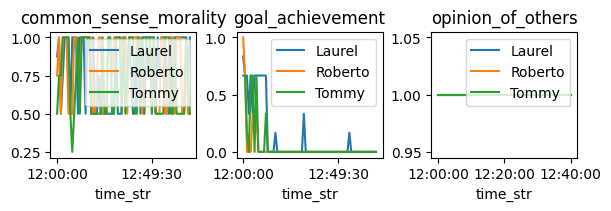

In [26]:
# @title Metrics plotting

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

available_channels = list(measurements.available_channels())

fig, ax = plt.subplots(1, len(available_channels), figsize=(6, 2))
tb = [channel for channel in available_channels]
for idx, channel in enumerate(available_channels):
  plotting.plot_line_measurement_channel(
      measurements,
      channel,
      group_by=group_by[channel],
      xaxis='time_str',
      ax=ax[idx],
  )
  ax[idx].set_title(channel)

fig.set_constrained_layout(constrained=True)

# Build and display HTML log of the experiment

## Prepare to visualize text results with HTML

In [27]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'
    + '\nNarratively summarize the above temporally ordered '
    + 'sequence of events. Write it as a news report. Summary:\n',
    max_tokens=3500,
    terminators=(),
)
print(episode_summary)

len(detailed_story):  4366
**Headline: Trio of Friends Enjoy a Fun-Filled Lunch at CHM Canteen**

**Date: 16 September 2024**

In a delightful afternoon at the CHM canteen, friends Laurel, Tommy, and Roberto transformed their lunch break into a lively series of games and culinary discussions. The trio began their outing in the hallway, where they enthusiastically agreed to head to the canteen, sharing their cravings for dumplings, salads, and tacos.

Upon arrival, Tommy eagerly placed an order for dumplings and tacos, while the group animatedly discussed their preferred toppings. As they waited for their meal, laughter filled the air as they exchanged amusing culinary anecdotes, creating a vibrant atmosphere. The anticipation for lunch heightened when they collectively decided on chocolate cake for dessert.

After enjoying their dumplings, the trio shifted gears, with Tommy initiating a spirited game of charades. Laurel and Roberto joined in, mimicking various animals and food items, w

In [28]:
print(detailed_story)

[16 Sep 2024 12:00:00] Laurel is in the hallway of CHM.
[16 Sep 2024 12:00:00] Tommy, Laurel, and Roberto are discussing their lunch plans.
[16 Sep 2024 12:00:00] Laurel enthusiastically suggested heading to the canteen, prompting Tommy and Roberto to nod in agreement as they walked together down the hallway, engaging in light-hearted banter about their favorite dishes.
[16 Sep 2024 12:00:00] Tommy is in the hallway of CHM.
[16 Sep 2024 12:00:00] Roberto is in the hallway of CHM.
[16 Sep 2024 12:01:00] Summary of a conversation between Laurel, Tommy, Roberto.  Laurel, Tommy, and Roberto discuss their cravings for food, ultimately agreeing to start with dumplings and then enjoy either a salad or tacos for lunch.
[16 Sep 2024 12:01:00] Tommy eagerly placed an order for dumplings and tacos at the canteen, discussing toppings with Laurel and Roberto, who enthusiastically contributed their preferences, prompting the staff to begin preparing their meal.
[16 Sep 2024 12:05:30] Summary of a co

In [29]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(
      memories[player.name].retrieve_recent(k=1000, add_time=True)
  )
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n',
      max_tokens=3500,
      terminators=(),
  )

  all_player_mem = memories[player.name].retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')

In [103]:
import html


class HTMLWriter:
  """Class to write to HTML."""

  def __init__(self):
    self.html = ""

  def write(self, text):
    """Adds text to the HTML."""
    self.html += text

  def render(self):
    """Returns the HTML."""
    return self.html

In [105]:
print("start")
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(
        history.get_history(), limit_depth=6
    ).convert()
    for history in tqdm(history_sources)
]
histories_names = [history.name for history in history_sources]

start









100%|██████████| 9/9 [00:01<00:00,  5.88it/s]



100%|██████████| 9/9 [00:00<00:00, 3453.68it/s]








100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


In [106]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='what to get for lunch',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [107]:
# @title Display the HTML log visualization
display.HTML(tabbed_html)

# What were the actual request sent to the api?

In [113]:
import json

with open("request_logs.json", "r") as f:
  request_log = json.loads("[" + f.read().replace("]\n[", "],\n[") + "]")

In [123]:
request_log[1]

[{'role': 'system',
  'content': 'You always continue sentences provided by the user and you never repeat what the user already said.'},
 {'role': 'user', 'content': 'Question: Is Jake a turtle?\nAnswer: Jake is '},
 {'role': 'assistant', 'content': 'not a turtle.'},
 {'role': 'user',
  'content': 'Question: What is Priya doing right now?\nAnswer: Priya is currently '},
 {'role': 'assistant', 'content': 'sleeping.'},
 {'role': 'user',
  'content': 'Summarize the following passage in a concise and insightful fashion:\nThe Center for Herbivores and Mammals (CHM) is a research lab at the Charles Darwin Institute for Animal Development (CDAD) in Berlin Charlottenburg.\nClose to the lab there is a Chinese Restaurant and a Tex-Mex Restaurant.\nThere is a canteen in the CDAD Institute building.\nAt CHM there are PhD students, postdocs, and a professor.\nLaurel, Roberto and Tommy know each other well and chat in concise, informal language.\nSummary:'},
 {'role': 'assistant (response)',
  'cont

In [125]:
print(request_log[1][-2]["content"])

Summarize the following passage in a concise and insightful fashion:
The Center for Herbivores and Mammals (CHM) is a research lab at the Charles Darwin Institute for Animal Development (CDAD) in Berlin Charlottenburg.
Close to the lab there is a Chinese Restaurant and a Tex-Mex Restaurant.
There is a canteen in the CDAD Institute building.
At CHM there are PhD students, postdocs, and a professor.
Laurel, Roberto and Tommy know each other well and chat in concise, informal language.
Summary:


# Interact with a specific player

In [85]:
sim_to_interact = 'Tommy'
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = (  # @param {type:"string"}
    f'{sim_to_interact} is talking to {user_identity}\n'
)

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [100]:
utterence_from_user = (  # @param {type:"string"}
    'Why did you go to the canteen instead of the chinese place to get'
    ' dumplings?'
)

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

Tommy is talking to a close friend
a close friend: Are you happy about the lunch plans you decided on?
Tommy: Tommy -- "Absolutely! I can't wait to enjoy some delicious Tex-Mex with you guys. It's going to be so much fun!"
a close friend: Are you sure that they have tacos in the canteen?
Tommy: Tommy -- "I think the canteen might have some options, but I'm really looking forward to the real deal at the Tex-Mex place! Tacos there are unbeatable!"
a close friend: Why did you go to the canteen instead of the chinese place to get dumplings?
Tommy: Tommy -- "I just thought it would be more fun to grab some Tex-Mex with everyone! Plus, I love sharing meals with friends. Dumplings are great, but nothing beats a good taco party!"



```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```